### DSPT6 - Adding Data Science to a Web Application

The purpose of this notebook is to demonstrate:
- Simple online analysis of data from a user of the Twitoff app or an API
- Train a more complicated offline model, and serialize the results for online use

In [5]:
import sqlite3
import pickle
import pandas as pd

In [6]:
# Connect to sqlite database
conn = sqlite3.connect('/Users/markmorelos/Desktop/twitoff.sqlite3')

In [7]:
def get_data(query, conn):
    '''Function to get data from SQLite DB'''
    
    cursor = conn.cursor()
    result = cursor.execute(query).fetchall()

    # Get columns from cursor object
    columns = list(map(lambda x: x[0], cursor.description))

    # Assign to DataFrame
    df = pd.DataFrame(data=result, columns=columns)
    return df

In [8]:
import pickle
sql = '''
SELECT 
	tweet.id,
	tweet.tweet, 
	tweet.embedding,
	user.username
FROM tweet
JOIN user on tweet.user_id = user.id;
'''

df = get_data(sql, conn)
df['embedding_decoded'] = df.embedding.apply(lambda x: pickle.loads(x))
print(df.shape)
df.head(2)

(12291, 5)


,id,tweet,embedding,username,embedding_decoded
0,23048456524,"Worth a read, I liked this Economist article a...",b'\x80\x04\x95\xee\x11\x00\x00\x00\x00\x00\x00...,billgates,"[-0.07537176, 0.27606362, -0.0547825, 0.014415..."
1,23048600560,"Another interesting article, this one on a pro...",b'\x80\x04\x95\xee\x11\x00\x00\x00\x00\x00\x00...,billgates,"[-0.14114963, 0.17626844, -0.18227336, 0.10240..."


In [9]:
import pickle

pickle.loads(df.embedding.iloc[0])

[-0.07537176,
 0.27606362,
 -0.0547825,
 0.014415297,
 0.048471157,
 0.1344528,
 0.034852736,
 -0.13165164,
 -0.09287855,
 1.8195804,
 -0.35756737,
 0.0083785,
 0.036499508,
 -0.09763726,
 -0.15378742,
 -0.12513152,
 -0.021516098,
 0.87476426,
 -0.13361092,
 -0.06305565,
 0.10453774,
 0.0867665,
 0.0856708,
 -0.15628012,
 -0.022448253,
 -0.0861542,
 0.015637342,
 0.0011766035,
 0.024040747,
 -0.0052763885,
 0.006839879,
 0.086689845,
 0.018314036,
 -0.0053215027,
 0.052583106,
 -0.08845799,
 0.017753331,
 -0.06814327,
 -0.10487236,
 -0.16814525,
 0.029557467,
 0.077633604,
 0.061465006,
 -0.029583257,
 -0.020891221,
 0.046604,
 -0.0857215,
 -0.024300002,
 0.110915765,
 -0.041792568,
 -0.16577193,
 0.118934,
 0.053269453,
 -0.11591138,
 0.093803294,
 -0.02830835,
 -0.03332862,
 -0.09134032,
 0.13034464,
 -0.1285244,
 -0.11049751,
 -0.15019597,
 -0.14106521,
 0.19856635,
 0.10652901,
 -0.26242393,
 0.003181552,
 -0.068966456,
 -0.042476665,
 0.16947964,
 0.011933951,
 0.021394257,
 0.044

In [10]:
df.username.value_counts()

billgates      2889
barackobama    2766
jimmyfallon    2353
KingJames      2193
nasa           1693
elonmusk        397
Name: username, dtype: int64

In [11]:
import numpy as np

user1_embeddings = df.embedding_decoded[df.username=='barackobama']
user2_embeddings = df.embedding_decoded[df.username=='jimmyfallon']
embeddings = pd.concat([user1_embeddings, user2_embeddings])

#create embeddings dataframe
embeddings_df = pd.DataFrame(embeddings.to_list(),
                            columns=[f'dom{i}' for i in range(300)])
labels = np.concatenate([np.ones(len(user1_embeddings)),
                        np.zeros(len(user2_embeddings))])
print(embeddings_df.shape, labels.shape)

(5119, 300) (5119,)


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    embeddings_df, labels, test_size=0.25, random_state=42
)

print(X_train.shape, X_test.shape)

(3839, 300) (1280, 300)


In [13]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [14]:
from sklearn.metrics import classification_report, plot_confusion_matrix

y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       564
         1.0       0.96      0.96      0.96       716

    accuracy                           0.95      1280
   macro avg       0.95      0.95      0.95      1280
weighted avg       0.95      0.95      0.95      1280



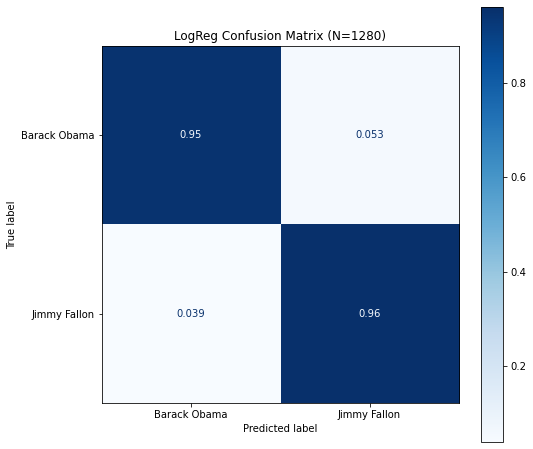

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(log_reg, X_test, y_test, 
                      normalize='true', cmap='Blues', 
                      display_labels=['Barack Obama', 'Jimmy Fallon'], ax=ax)
plt.title(f'LogReg Confusion Matrix (N={X_test.shape[0]})');

In [16]:
import spacy

# Load SpaCy pre-trained model
nlp = spacy.load('en_core_web_md', disable=['tagger', 'parser'])

def vectorize_tweet(nlp, tweet_text):
    '''This function returns the SpaCy embeddings for an input text'''
    return list(nlp(tweet_text).vector)

In [17]:
new_embedding = vectorize_tweet(nlp, "The innovation displayed during this pandemic is unprecedented.")
new_embedding[0:5]

[-0.11192022, 0.27545333, 0.17263512, -0.096563116, -0.06543166]

In [18]:
log_reg.predict([new_embedding])

array([1.])

In [20]:
pickle.dump(log_reg, open("../models/log_reg.pkl", "wb"))